# 第12組_社群媒體分析_期末專案_網路圖

## 組別：Group 12
## 題目：PTT論壇AI相關議題的語料分析與趨勢探勘
### 使用工具：Python

M134020005 馮祐倫  
M134020051 柯昆霖

報告影片連結：https://youtu.be/NcM5DaE0uTg


## 目的
2023 年起，生成式 AI 帶來了前所未有的變革浪潮。從 ChatGPT 到 Midjourney、從人工到自動化，AI 正以前所未有的速度滲透人們的工作與生活。  
而在台灣最具代表性的網路論壇之一——PTT，鄉民們也開始熱烈討論這波浪潮帶來的機會與焦慮。

本專案計畫分析和說明以下三個核心問題：

1. PTT 社群如何看待 AI 在職場與科技工作的角色與影響？

2. 各主要實體（如：公司、技術、人物等）在討論中扮演什麼樣的網絡位置與影響力？

3. 不同主題下的情緒傾向與輿論熱點為何？


透過各種不同的分析，進一步揭示各實體在社群中的連結強度、討論中心性與潛在社群結構：

1. 情緒分析 (Sentiment Analysis)

    目的：判斷貼文中對 AI 的整體情感傾向（正向、中立、負向）。

    應用：了解網友對 AI 技術、AI 應用在工作上，以及 AI 對職場未來影響的情緒態度，並進一步探索情緒隨時間或議題的變化趨勢。

2. 主題模型分析 (Topic Modeling)

    目的：藉由 BERTopic 方法，自動挖掘貼文中的主題結構，找出幾大核心討論議題。

    應用：了解在「AI+工作」範疇內，網友最關注哪些面向（例如「AI 自動化取代工作」、「AI 招募面試應用」、「AI 技能學習建議」……），並分析每個主題的情緒分佈與實體共現情況。

3. 命名實體識別 (NER)

    目的：自動偵測並抽取貼文中的組織（ORG）、人物（PERSON）、產品（PRODUCT）、技術（TECH）等實體。

    應用：辨識出在 AI 討論中最常被提及的公司（如台積電、NVIDIA）、研究單位、意見領袖，或是關鍵技術名詞，為後續網路圖與主題建模提供實體基礎。

4. 網路圖構建 (Network Graph Analysis)

    目的：將貼文中的實體 (經由 NER) 與關鍵詞或使用者互動關係視覺化為節點與邊，構建實體共現網路或使用者互動網路。

    應用：揭示 AI 議題中各實體之間的關聯強度（例如哪些公司或技術一起被討論最多）、意見領袖的社群結構，以及不同主題或情緒社群的網絡分布。


綜合以上，能更立體地描繪出台灣論壇使用者在 AI 職場議題中的討論趨勢、關注焦點與情緒反應。


In [1]:
! pip install tqdm
! pip install pandas
! pip install matplotlib
! pip install pyvis
! pip install networkx
! pip install numpy

In [2]:
import os
import random

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import Counter
from pyvis.network import Network
import networkx as nx
import numpy as np

In [3]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/研究所專用資料夾/碩一/碩班課程/SMA/final_project') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['requirements.txt',
 'dict',
 'font',
 'data',
 'demo',
 'plot',
 'Network.html',
 'Network3.html',
 'Network4.html',
 'Network5.html',
 'Network6.html',
 'Network7.html',
 'Network8.html',
 'Network2.html',
 'BERT_NER.ipynb',
 '網路圖.ipynb']

### 載入資料

## 資料集概覽

此資料集收集自台灣的社群媒體平台 PTT。PTT「工作」、「職場」、「科技工作」三個版中，針對含有 “AI” 關鍵字的貼文。資料收集範圍從 2024 年 5 月 1 日到 2025 年 5 月 1 日，共包含 1041 筆資料。

## 資料欄位說明

資料集包含以下 10 個欄位：

1. `system_id`: 系統編號
2. `artComment`: 文章評論
3. `artDate`: 文章日期
4. `insertedDate`: 插入日期
5. `artContent`: 文章內容
6. `artCatagory`: 文章類別
7. `dataSource`: 資料來源
8. `artPoster`: 發文者
9. `artTitle`: 文章標題。
10. `artUrl`: 文章網址

In [4]:
df = pd.read_csv('data/Merged.csv')
df.head()

system_id                                             artUrl  \
0         1  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...   
1         2  https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...   
2         3  https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...   
3         4  https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...   
4         5  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...   

                      artTitle              artDate     artPoster artCatagory  \
0  Re:[面試]104待遇寫4w~4.8w你應該開多少？  2024-05-01 16:50:30          LaAc    Tech_Job   
1       [新聞]年後轉職最熱門公司出爐前三名台積電、  2024-05-01 17:24:04  qazxc1156892    Tech_Job   
2      [新聞]訓練台版AI語言模型，許永真：盼讓百工  2024-05-01 17:48:08         pl132    Tech_Job   
3       [新聞]首屆台法科研會議吳政忠：六大領域可望  2024-05-01 21:41:58   createlight    Tech_Job   
4            [心得]電子業PM面試紀錄（長文）  2024-05-01 21:43:46       tin8420    Tech_Job   

                                          artContent  \
0  很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...   
1  新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...   
2  訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...   
3  https://www.epochtimes.com/b5/24/4/30/n1423755...   
4  https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "kwanles", "c...    27.53.241.196   
1  [{"cmtStatus": "→", "cmtPoster": "abc21086999"...    223.137.1.131   
2  [{"cmtStatus": "→", "cmtPoster": "ling621", "c...    180.177.2.112   
3  [{"cmtStatus": "噓", "cmtPoster": "unima", "cmt...    114.39.34.219   
4  [{"cmtStatus": "推", "cmtPoster": "KMTlikesshit...  118.231.160.114   

          insertedDate dataSource  
0  2024-05-02 02:19:38        ptt  
1  2024-05-02 02:19:38        ptt  
2  2024-05-02 02:19:38        ptt  
3  2024-05-02 02:19:38        ptt  
4  2024-05-02 02:19:38        ptt

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2456 non-null   object
 1   artUrl        2456 non-null   object
 2   artTitle      2456 non-null   object
 3   artDate       2456 non-null   object
 4   artPoster     2456 non-null   object
 5   artCatagory   2456 non-null   object
 6   artContent    2456 non-null   object
 7   artComment    2456 non-null   object
 8   e_ip          2439 non-null   object
 9   insertedDate  2456 non-null   object
 10  dataSource    2456 non-null   object
dtypes: object(11)
memory usage: 211.2+ KB


In [6]:
# Path to the custom font
font_path = 'font/TaipeiSansTCBeta-Regular.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Taipei Sans TC Beta


### 資料前處理

In [7]:
# 複製原始資料集
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artTitle', 'artCatagory', 'dataSource', 'insertedDate']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artUrl              artDate  \
0  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...  2024-05-01 16:50:30   
1  https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...  2024-05-01 17:24:04   
2  https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...  2024-05-01 17:48:08   
3  https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...  2024-05-01 21:41:58   
4  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...  2024-05-01 21:43:46   
5  https://www.ptt.cc/bbs/Tech_Job/M.1714571075.A...  2024-05-01 21:44:23   
6  https://www.ptt.cc/bbs/Tech_Job/M.1714608383.A...  2024-05-02 08:06:20   
7  https://www.ptt.cc/bbs/Tech_Job/M.1714621623.A...  2024-05-02 11:47:00   
8  https://www.ptt.cc/bbs/Tech_Job/M.1714625026.A...  2024-05-02 12:43:42   
9  https://www.ptt.cc/bbs/Tech_Job/M.1714629835.A...  2024-05-02 14:03:51   

      artPoster                                         artContent  \
0          LaAc  很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...   
1  qazxc1156892  新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...   
2         pl132  訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...   
3   createlight  https://www.epochtimes.com/b5/24/4/30/n1423755...   
4       tin8420  https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...   
5    hvariables  https://ec.ltn.com.tw/article/breakingnews/465...   
6      jeff0025  那「一通電話」白打了？台積電恐放棄在銅鑼建先進封裝廠\n\n〔記者洪友芳／新竹報導〕\n晶圓...   
7   sugaryeh000  https://inews.hket.com/article/3753047\n科企裁員潮｜...   
8    LBJnot1to7  今年要繳稅335萬…眾人秒跪！10年工程師：感謝「海產店」照顧\nhttps://finan...   
9    Angels5566  外媒：台積電作為世界領導者 股價實在太便宜\n\n高佳菁／核稿編輯\n\n〔財經頻道／綜合報...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "kwanles", "c...    27.53.241.196   
1  [{"cmtStatus": "→", "cmtPoster": "abc21086999"...    223.137.1.131   
2  [{"cmtStatus": "→", "cmtPoster": "ling621", "c...    180.177.2.112   
3  [{"cmtStatus": "噓", "cmtPoster": "unima", "cmt...    114.39.34.219   
4  [{"cmtStatus": "推", "cmtPoster": "KMTlikesshit...  118.231.160.114   
5  [{"cmtStatus": "→", "cmtPoster": "SSSONIC", "c...      1.162.59.27   
6  [{"cmtStatus": "→", "cmtPoster": "yun0615ch", ...   175.98.141.254   
7  [{"cmtStatus": "推", "cmtPoster": "qazxc1156892...     49.186.66.91   
8  [{"cmtStatus": "推", "cmtPoster": "physicsdk", ...     114.43.64.14   
9  [{"cmtStatus": "推", "cmtPoster": "xSAUCEx", "c...  223.140.249.193   

                                            sentence  
0  很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。。前陣子業界很凍（現在好像也.....  
1  新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電。2024-05-01 11:...  
2  訓練台版 AI 語言模型，許永真：盼讓百工百業商用， 4 月啟動 TAIDE 計畫，研發台版...  
3   吳政忠：六大領域可望締造雙贏， Giry）。（國，科會提供）。【大紀元2024年04月30...  
4   威剛 — Sales PM，面試地點在中和，結果搞小烏龍跑錯棟+樓層，有稍微遲到一下下，感...  
5   須靠外籍人才填補。2024/05/01 15:57， Long）、「商業市場」（Marke...  
6  那「一通電話」白打了？台積電恐放棄在銅鑼建先進封裝廠。〔記者洪友芳／新竹報導〕，晶圓代工廠力...  
7  　部分職位轉移到印度和墨西哥。，Google母企Alphabet（美：GOOG）據報上星期公...  
8  今年要繳稅335萬…眾人秒跪！10年工程師：感謝「海產店」照顧， 該哭該笑？，」「我繳3萬多...  
9  外媒：台積電作為世界領導者 股價實在太便宜。高佳菁／核稿編輯。〔財經頻道／綜合報導〕《電訊報...

### 處理留言

In [8]:
import ast # 匯入 ast 模組
tqdm.pandas()

# 處理某篇文章的所有留言 (取出留言者與狀態)
def get_comment_info(com):
    # 初始化預設的回傳值
    commenters, comment_status = [], []

    # 檢查 com 是否為字串，以過濾掉 NaN 或其他非字串類型
    if not isinstance(com, str):
        return pd.Series([commenters, comment_status])

    try:
        # 使用更安全的 ast.literal_eval 來解析字串
        comment_list = ast.literal_eval(com)

        # 確保解析後是列表格式
        if isinstance(comment_list, list):
            for i in comment_list:
                # 使用 .get() 方法更安全地取值，避免因缺少 key 而出錯
                commenters.append(i.get('cmtPoster'))
                comment_status.append(i.get('cmtStatus'))

    except (ValueError, SyntaxError):
        # 如果 ast.literal_eval 解析失敗 (例如字串格式錯誤)，
        # 則不執行任何操作，直接回傳預設的空列表
        pass

    return pd.Series([commenters, comment_status])

# 將留言者與狀態分開
clear_df[['commenters', 'comment_status']] = clear_df['artComment'].apply(get_comment_info)
clear_df.head()

artUrl              artDate  \
0  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...  2024-05-01 16:50:30   
1  https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...  2024-05-01 17:24:04   
2  https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...  2024-05-01 17:48:08   
3  https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...  2024-05-01 21:41:58   
4  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...  2024-05-01 21:43:46   

      artPoster                                         artContent  \
0          LaAc  很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...   
1  qazxc1156892  新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...   
2         pl132  訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...   
3   createlight  https://www.epochtimes.com/b5/24/4/30/n1423755...   
4       tin8420  https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "kwanles", "c...    27.53.241.196   
1  [{"cmtStatus": "→", "cmtPoster": "abc21086999"...    223.137.1.131   
2  [{"cmtStatus": "→", "cmtPoster": "ling621", "c...    180.177.2.112   
3  [{"cmtStatus": "噓", "cmtPoster": "unima", "cmt...    114.39.34.219   
4  [{"cmtStatus": "推", "cmtPoster": "KMTlikesshit...  118.231.160.114   

                                            sentence  \
0  很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。。前陣子業界很凍（現在好像也.....   
1  新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電。2024-05-01 11:...   
2  訓練台版 AI 語言模型，許永真：盼讓百工百業商用， 4 月啟動 TAIDE 計畫，研發台版...   
3   吳政忠：六大領域可望締造雙贏， Giry）。（國，科會提供）。【大紀元2024年04月30...   
4   威剛 — Sales PM，面試地點在中和，結果搞小烏龍跑錯棟+樓層，有稍微遲到一下下，感...   

                                          commenters  \
0  [kwanles, cutearia, cityhunter04, afking, afki...   
1  [abc21086999, brightest, Skydier, yun0615ch, c...   
2  [ling621, ling621, CalvinBryant, qwe78971, mag...   
3                              [unima, oldchang1205]   
4  [KMTlikesshit, Delyan, iditiror, yjlee0829, ba...   

                                      comment_status  
0            [推, 推, →, 推, →, →, →, →, 推, 推, →, →, 推]  
1  [→, 推, 推, →, 推, 推, →, 推, 推, →, 推, →, →, →, 推, ...  
2                  [→, →, 噓, 推, 推, 推, →, →, 推, 噓, 噓]  
3                                             [噓, 噓]  
4  [推, 推, 推, 推, 推, 推, 推, 推, →, →, 推, 推, 推, 推, →, ...

In [9]:
# 展開留言者與狀態
clear_df = clear_df.explode(['commenters', 'comment_status'])

social_df = clear_df[['artPoster','artUrl','commenters','comment_status']]

social_df.reset_index(drop=True, inplace=True)

social_df.head()

artPoster                                             artUrl    commenters  \
0      LaAc  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...       kwanles   
1      LaAc  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...      cutearia   
2      LaAc  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...  cityhunter04   
3      LaAc  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...        afking   
4      LaAc  https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...        afking   

  comment_status  
0              推  
1              推  
2              →  
3              推  
4              →

In [10]:
social_df['comment_status'].value_counts()

comment_status
→    31129
推    24650
噓     5655
Name: count, dtype: int64

### 文章留言數量分析

In [11]:
top_comments_df = social_df.groupby('artUrl')['commenters'].count().sort_values(ascending=False)
top_comments_df.head(10)

artUrl
https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A.938.html    833
https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A.1E7.html    619
https://www.ptt.cc/bbs/Tech_Job/M.1733531724.A.D42.html    558
https://www.ptt.cc/bbs/Tech_Job/M.1729777721.A.2A0.html    522
https://www.ptt.cc/bbs/Tech_Job/M.1741095802.A.FF4.html    503
https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A.5C4.html    452
https://www.ptt.cc/bbs/Tech_Job/M.1736693473.A.695.html    451
https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A.113.html    434
https://www.ptt.cc/bbs/Tech_Job/M.1738903517.A.64A.html    404
https://www.ptt.cc/bbs/Tech_Job/M.1721279074.A.30F.html    402
Name: commenters, dtype: int64

可見有些文章的留言數量非常多，這些文章可能是熱門話題。

In [12]:
# 只取留言數量前 10 文章
social_df_top = social_df[social_df['artUrl'].isin(top_comments_df.head(10).index)]

### 使用者與文章的網路分析

In [13]:
# 篩選資料
def get_top_users(modify_df, n=30):
    user_count = Counter(modify_df['artPoster'].tolist() * 10 + modify_df['commenters'].tolist())
    top_users = {user for user, count in user_count.most_common(n)}
    return modify_df[modify_df['artPoster'].isin(top_users) & modify_df['commenters'].isin(top_users)]

# Filter edges to include only interactions between top users
top_filtered_df = get_top_users(social_df_top, n=500)

top_filtered_df.head()

artPoster                                             artUrl  \
7385  Reewalker  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   
7387  Reewalker  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   
7388  Reewalker  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   
7389  Reewalker  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   
7390  Reewalker  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   

      commenters comment_status  
7385       ltytw              推  
7387  heyhey0511              推  
7388  heyhey0511              →  
7389    dearjohn              推  
7390       ltytw              →

In [14]:
# 留言者對文章，狀態為 weight
re_df = top_filtered_df[['commenters','artUrl','comment_status']].rename(columns = {'commenters':'src','artUrl':'dis','comment_status':'weight'})
re_df = re_df[~re_df['src'].isna()]
re_df.head()

src                                                dis weight
7385       ltytw  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...      推
7387  heyhey0511  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...      推
7388  heyhey0511  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...      →
7389    dearjohn  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...      推
7390       ltytw  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...      →

In [15]:
def convert_status(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1

re_df['weight'] = re_df['weight'].map(convert_status)

# 計算某位留言者對某篇文章的總分數
re_df = re_df.groupby(['src','dis']).sum().reset_index()
re_df

src                                                dis  weight
0       AdomiZA  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       5
1    Agamemnonk  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...       3
2        AirLee  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       4
3     Alderamin  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       4
4       AlenCKH  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...       3
..          ...                                                ...     ...
738     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A...       3
739     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1733531724.A...       2
740     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1741095802.A...       3
741     zoo2020  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...       4
742    zorroptt  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...       6

[743 rows x 3 columns]

### 建立使用者與文章的網路

In [16]:
# 設定分數低的為紅色
def get_color(w):
  if w>0:
    return 'green'
  else:
    return 'red'

re_df['color'] = re_df.weight.map(get_color)
re_df

src                                                dis  weight  \
0       AdomiZA  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       5   
1    Agamemnonk  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...       3   
2        AirLee  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       4   
3     Alderamin  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...       4   
4       AlenCKH  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...       3   
..          ...                                                ...     ...   
738     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A...       3   
739     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1733531724.A...       2   
740     zhi5566  https://www.ptt.cc/bbs/Tech_Job/M.1741095802.A...       3   
741     zoo2020  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...       4   
742    zorroptt  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...       6   

     color  
0    green  
1    green  
2    green  
3    green  
4    green  
..     ...  
738  green  
739  green  
740  green  
741  green  
742  green  

[743 rows x 4 columns]

In [17]:
# 發文者對文章
po_df = top_filtered_df[['artPoster', 'artUrl']].rename(columns={'artPoster': 'src', 'artUrl': 'dis'}).drop_duplicates()

In [18]:
import IPython
# 人為綠色節點 po文為橘色節點

# 建立一個網路圖
netWork = Network(notebook=True, cdn_resources='in_line', directed=True)

# 所有發文者＋留言者
person = list(set(po_df.src.unique().tolist() + re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()

# 確保top_comments_df是一個字典，key是文章URL，value是留言數
top_comments_dict = dict(zip(url, [int(top_comments_df[i]) for i in url]))

# 加入節點（人）
netWork.add_nodes(
    nodes=person,
    value=[1 for i in range(len(person))],
    color=['#66CDAA' for i in range(len(person))],
    title=person
)

# 加入節點（文章）
netWork.add_nodes(
    nodes=url,
    color=['#FFB366' for i in range(len(url))],
    title=url,
    value=[int(top_comments_df[i]) for i in url]
)

# 加入邊（發文者 -> 文章）
for i in po_df.to_numpy():
    netWork.add_edge(i[0], i[1], width=2, color='grey')
# 加入邊（留言者 -> 文章），顏色為某發文者對該文章的總分（>0:綠; <=0:紅）
for i in re_df.to_numpy():
    netWork.add_edge(i[0], i[1], width=2, color=i[3])

# 設定layout，圖節點之間的斥力
netWork.repulsion()

if not os.path.exists('plot'):
    os.makedirs('plot')

# netWork.show('plot/Network.html')
netWork.save_graph("./Network.html")
IPython.display.HTML('Network.html')

In [19]:
# Find Top 10 Articles Name and URL
pd.merge(df[df['artUrl'].isin(top_comments_df.head(10).index)][['artTitle', 'artUrl', 'artPoster']], top_comments_df.head(10), left_on='artUrl', right_index=True)

artTitle  \
217      [新聞]黃仁勳喊「台灣是重要國家」　陸媒點名了   
397      [新聞]川普批搶美國晶片生意　台積電法說前跌出   
423    [新聞]黃仁勳要求「台積電CoWoS專線」被拒　雙   
721    [新聞]前科男尾隨26歲女CEO！闖入家中性侵用磚   
842      [新聞]「我們連無人機晶片都沒有」劉鏡清點名軍   
952          [新聞]下一個數兆美元產業黃仁勳點名了   
1058    [新聞]抗DeepSeek賴清德：速建構主權AI   
1161    Fw:[閒聊]台積電重鎮轉移美國對房價利還是弊？   
1174  Fw:[新聞]想離職被董座殺！雲云科技技術長離職文曝   
1306       Re:[心得]2024亞利桑那工作的那些事   

                                                 artUrl   artPoster  \
217   https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   Reewalker   
397   https://www.ptt.cc/bbs/Tech_Job/M.1721279074.A...   Reewalker   
423   https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A...   Reewalker   
721   https://www.ptt.cc/bbs/Tech_Job/M.1729777721.A...        cjol   
842   https://www.ptt.cc/bbs/Tech_Job/M.1733531724.A...        cjol   
952   https://www.ptt.cc/bbs/Tech_Job/M.1736693473.A...  hvariables   
1058  https://www.ptt.cc/bbs/Tech_Job/M.1738903517.A...        cjol   
1161  https://www.ptt.cc/bbs/Tech_Job/M.1741095802.A...  Zoanthropy   
1174  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...      oijkue   
1306  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...     inCraft   

      commenters  
217          833  
397          402  
423          452  
721          522  
842          558  
952          451  
1058         404  
1161         503  
1174         619  
1306         434

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Interaction within Users 使用者之間的互動</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Select the Top Users 選擇前幾名使用者</div>

In [20]:
pos_comment = get_top_users(social_df, n=150)
pos_comment = pos_comment[~pos_comment['commenters'].isna()]
pos_comment.head(10)

artPoster                                             artUrl  \
16   qazxc1156892  https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...   
53          pl132  https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...   
71        tin8420  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...   
262       tin8420  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...   
301       tin8420  https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...   
314    hvariables  https://www.ptt.cc/bbs/Tech_Job/M.1714571075.A...   
315    hvariables  https://www.ptt.cc/bbs/Tech_Job/M.1714571075.A...   
325      jeff0025  https://www.ptt.cc/bbs/Tech_Job/M.1714608383.A...   
337      jeff0025  https://www.ptt.cc/bbs/Tech_Job/M.1714608383.A...   
343      jeff0025  https://www.ptt.cc/bbs/Tech_Job/M.1714608383.A...   

       commenters comment_status  
16      yun0615ch              →  
53        francej              噓  
71    Alleyesonme              推  
262     wsad50232              推  
301        awwman              推  
314      kyle5241              推  
315          dxdy              噓  
325     yun0615ch              →  
337  qazxc1156892              推  
343     physicsdk              推

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the score 計算分數</div>

In [21]:
pos_comment['score'] = pos_comment['comment_status'].apply(lambda r: convert_status(r))

# 某留言者對某發文者的總分
pos_comment = pos_comment.groupby(['commenters', 'artPoster']).sum('score').reset_index()
pos_comment = pos_comment[pos_comment.score >= 0]
pos_comment = pos_comment[pos_comment['commenters'] != pos_comment.artPoster]

pos_comment

commenters     artPoster  score
0    Alleyesonme      jeff0025      0
1    Alleyesonme       tin8420      2
2    Alleyesonme         zacks      2
6         DrTech        Amed21      8
7         DrTech    Angels5566      1
..           ...           ...    ...
724         yunf      wahaha23      3
725         yunf       xpradax      1
726         yunf         zxwxz      1
729        zxwxz  jackliao1990      1
730        zxwxz         pl132      5

[642 rows x 3 columns]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Create the Interaction Matrix 建立互動矩陣</div>

In [22]:
matrix = pd.pivot_table(pos_comment, index='commenters', columns='artPoster', values='score').fillna(0)
matrix.head()

artPoster    AAAB  AbsoluteDull  Alleyesonme  Amed21  Angels5566  BBMADE  \
commenters                                                                 
Alleyesonme   0.0           0.0          0.0     0.0         0.0     0.0   
DrTech        0.0           0.0          0.0     8.0         1.0     0.0   
JQK2          0.0           0.0          0.0     0.0         0.0     0.0   
KotoriCute    0.0           0.0          0.0     0.0         4.0     0.0   
LBJnot1to7    0.0           0.0          0.0     0.0         2.0     0.0   

artPoster    Bayou2270320  GuabaGua  IsaacBlanc  JHS  ...  wartwo  weiway  \
commenters                                            ...                   
Alleyesonme           0.0       0.0         0.0  0.0  ...     0.0     0.0   
DrTech                0.0       2.0         2.0  5.0  ...     0.0     0.0   
JQK2                  0.0       0.0         0.0  0.0  ...     0.0     0.0   
KotoriCute            0.0       0.0         0.0  0.0  ...     0.0     0.0   
LBJnot1to7            0.0       0.0         0.0  0.0  ...     0.0     0.0   

artPoster    willy9852398  xpradax  yokann  yun0615ch  zacks  zeus7668  \
commenters                                                               
Alleyesonme           0.0      0.0     0.0        0.0    2.0       0.0   
DrTech               15.0      0.0     3.0        0.0    2.0       0.0   
JQK2                  0.0      0.0     0.0        0.0    0.0       1.0   
KotoriCute            0.0      0.0     0.0        0.0    0.0       0.0   
LBJnot1to7            0.0      0.0     0.0        0.0    0.0       0.0   

artPoster    zxc8229748  zxwxz  
commenters                      
Alleyesonme         0.0    0.0  
DrTech              0.0   47.0  
JQK2                0.0    0.0  
KotoriCute          0.0    0.0  
LBJnot1to7          0.0    0.0  

[5 rows x 125 columns]

In [23]:
# 所有留言者與發文者
pers = np.unique(pos_comment[['commenters', 'artPoster']])

# 建立評分矩陣（留言者對發文者分數）
# 取得所有人對於其他人的分數（有方向性）
# 矩陣中的值 mat[i][j] 代表使用者 pers[i]（留言者）對使用者 pers[j]（發文者）的評分，
# 留言者和發文者之間的關係是有方向的（即，mat[i][j] 不一定等於 mat[j][i]）
matrix = pd.pivot_table(pos_comment, index='commenters', columns='artPoster', values='score').fillna(0) \
    .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
matrix.shape

(134, 134)

In [24]:
# 取得所有人與其他人互動分數總和（無方向，兩個方向分數相加）
# 矩陣中的每一對元素都對稱，即 mat_s[i][j] 等於 mat_s[j][i]
# 對稱矩陣中的值 mat_s[i][j] 表示使用者 pers[i] 與使用者 pers[j] 之間的互動總分。
# 透過將 pers[i] 對 pers[j] 的評分和 pers[j] 對 pers[i] 的評分相加而得到的。
# np.tril(mat, -1): 生成一個下三角矩陣（包括主對角線下方的所有元素，但不包括主對角線上的元素）
# np.triu(mat, 1): 生成一個上三角矩陣（包括主對角線上方的所有元素，但不包括主對角線上的元素）
tri = (np.tril(matrix, -1).T + np.triu(matrix, 1))
matrix_sum = tri + tri.T  # 上三角和下三角都包括在內，但對角線是 0
matrix_sum

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Interaction Matrix 可視化互動矩陣</div>

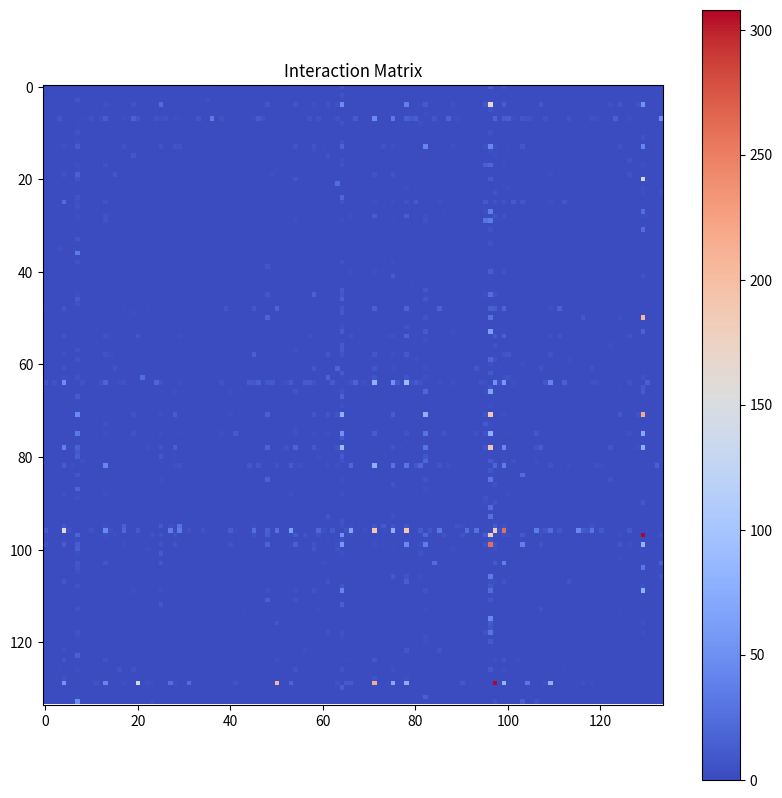

In [25]:
plt.figure(figsize=(10, 10))

plt.imshow(matrix_sum, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Interaction Matrix')
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Network of Users and Articles 可視化使用者與文章的網路</div>

In [26]:
# 產生隨機的顏色，畫圖使用
def random_color():
    r = lambda: random.randint(0, 255)
    return '#%02X%02X%02X' % (r(), r(), r())


def mat_present_graph(
    mat: np.array,
    node_id: list,
    node_type: list = None,
    node_value: list = None,
    directed=True,
    edge_color=None,
    scale=1
) -> Network:
    # 有方向或無方向
    if not directed:
        # 矩陣對稱
        if (mat == mat.transpose()).all():
            print('matrix is Symmetric')
        # 矩陣不對稱
        else:
            print('matrix is not Symmetric')

    # 設定節點的類別及顏色
    # 沒有分節點類別
    if node_type is None:
        c = random_color()
        node_colors = [c for i in range(len(node_id))]
        node_type = [" " for i in range(len(node_id))]
    # 有分節點類別
    else:
        node_color_map = {}
        for i in set(node_type):
            # 幫每個類別產生一個顏色
            while True:
                c = random_color()
                if c not in node_color_map.values():
                    break
            node_color_map[i] = c
        node_colors = [node_color_map[i] for i in node_type]

    # 如果沒有給邊的顏色，隨機產生一個
    if edge_color is None:
        edge_color = random_color()

    # 如果沒有給 node 值，就都分配 1
    if node_value is None:
        node_value = [1 for i in range(len(node_id))]

    # 建立圖
    net = Network(notebook=True, directed=directed, cdn_resources='in_line')

    titles_list = []
    for i, j in zip(node_id, node_type):
        titles_list.append(str(i) + ":" + str(j))

    net.add_nodes(
        nodes=node_id,
        value=node_value,
        label=node_id,
        title=titles_list,
        color=node_colors
    )

    for row in range(len(node_id)):
        for col in range(len(node_id)):
            if mat[row][col] > 0.:
                net.add_edge(
                    node_id[row], node_id[col], width=mat[row][col] / scale, color=edge_color, title=mat[row][col]
                )
    net.repulsion()
    return net

In [27]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_comment['commenters'].unique().tolist()
po_list = pos_comment['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))

for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')

In [28]:
# 繪製網路圖
net = mat_present_graph(matrix_sum, pers, node_type=node_type, directed=False, edge_color='grey', scale=10)

# net.show('plot/Network2.html')
netWork.save_graph("./Network2.html")
IPython.display.HTML('Network2.html')

matrix is Symmetric


In [29]:
# Find Top 10 Commenters
top_users = pd.DataFrame(pos_comment.groupby('commenters').sum('score')['score'].sort_values(ascending=False).head(10))
top_users

score
commenters        
physicsdk     1805
yunf          1464
gn01216674     755
DrTech         495
kyle5241       407
peter98        161
boards         145
dakkk          110
OyodoKai       108
scitamehtam     98

In [30]:
# Find Top 10 Posters
top_posters = pd.DataFrame(pos_comment.groupby('artPoster').sum('score')['score'].sort_values(ascending=False).head(10))
top_posters

score
artPoster          
hvariables      720
pl132           712
qazxc1156892    600
jeff0025        571
Angels5566      439
jackliao1990    349
cjol            278
KotoriCute      223
stpiknow        185
Lsamia          173

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Eigenvector Centrality 特徵向量中心性</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Eigenvector Centrality 計算特徵向量中心性</div>

In [31]:
# nx.Graph(mat_s): 將對稱矩陣 mat_s 轉換為 NetworkX 的無向圖對象
# nx.eigenvector_centrality: 計算圖中每個節點的特徵向量中心性
# max_iter=10000: 演算法的最大迭代次數，以確保演算法收斂。 特徵向量中心性的計算是一個迭代過程，可能需要多次迭代才能達到穩定狀態。
eigen_vector = np.array(list(nx.eigenvector_centrality(nx.Graph(matrix_sum), max_iter = 10000).values()))

# 將特徵向量中心性值歸一化到 [0, 1] 範圍內
eigen_vector = (eigen_vector - np.min(eigen_vector)) / (np.max(eigen_vector) - np.min(eigen_vector))

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Eigenvector Centrality 可視化特徵向量中心性</div>

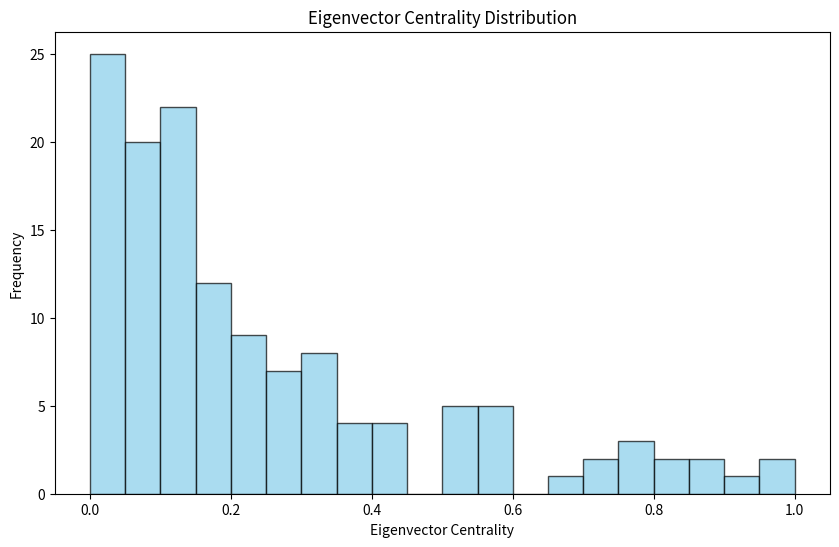

In [32]:
# 繪製特徵向量中心性的直方圖
plt.figure(figsize=(10, 6))
plt.hist(eigen_vector, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Assign the Value to the Nodes 將值分配給節點</div>

In [33]:
node_value = []
q = np.quantile(eigen_vector, [.2,.4,.6,.8])

for i in eigen_vector:
  # 越重要分數越高
  if i > q[3]:
    node_value.append(25)
  elif i >q[2]:
    node_value.append(20)
  elif i>q[1]:
    node_value.append(15)
  elif i>q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Network of Users and Articles with Eigenvector Centrality 可視化使用者之間的網路與特徵向量中心性</div>

In [34]:
net = mat_present_graph(mat = matrix_sum,node_id = pers,node_type = node_type,node_value = node_value,directed=False, scale=10)
# net.show('plot/Network3.html')
netWork.save_graph("./Network3.html")
IPython.display.HTML('Network3.html')

matrix is Symmetric


In [35]:
# Find Top 10 Users with Eigenvector Centrality
eigen_vector_df = pd.DataFrame(eigen_vector, index=pers, columns=['eigenvector_centrality'])
eigen_vector_df.sort_values(by='eigenvector_centrality', ascending=False).head(10)

eigenvector_centrality
gn01216674                  1.000000
qazxc1156892                0.981916
DrTech                      0.903783
physicsdk                   0.880062
jeff0025                    0.862834
jackliao1990                0.848858
pl132                       0.806689
KotoriCute                  0.799297
peter98                     0.783979
Angels5566                  0.782217

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: PageRank Algorithm PageRank 演算法</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the PageRank 計算 PageRank</div>

In [36]:
# Digraph 設定有向圖
# nx.DiGraph(mat): 使用 NetworkX 的 DiGraph 類別將矩陣 mat 轉換為有向圖物件。
# nx.pagerank(): 計算圖中每個節點的 PageRank 值
pagerank = np.array(list(nx.pagerank(nx.DiGraph(matrix)).values()))

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the PageRank 可視化 PageRank</div>

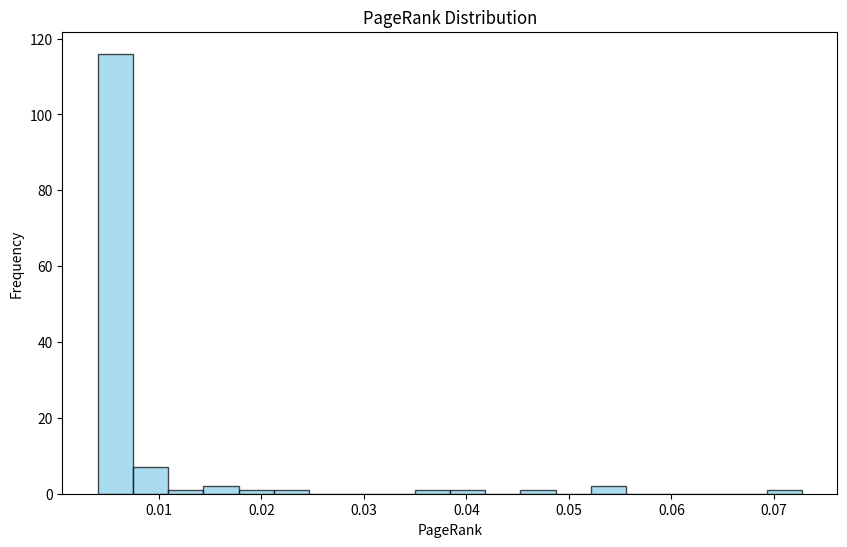

In [37]:
# 繪製 PageRank 的直方圖
plt.figure(figsize=(10, 6))
plt.hist(pagerank, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('PageRank Distribution')
plt.xlabel('PageRank')
plt.ylabel('Frequency')
plt.show()

In [38]:
net = mat_present_graph(mat=matrix, node_id=pers, node_type=node_type, node_value=(pagerank * 1000).tolist(), scale=10)

# net.show('plot/Network4.html')
netWork.save_graph("./Network4.html")
IPython.display.HTML('Network4.html')

In [39]:
# Find Top 10 Users with PageRank
pagerank_df = pd.DataFrame(pagerank, index=pers, columns=['pagerank'])
pagerank_df.sort_values(by='pagerank', ascending=False).head(10)

pagerank
jackliao1990  0.072765
Angels5566    0.054827
jeff0025      0.052314
hvariables    0.048606
pl132         0.040707
qazxc1156892  0.036110
KotoriCute    0.021544
stpiknow      0.017912
LinuxKernel   0.016091
Reewalker     0.015712

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Hit Score</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Hit Score 計算 Hit Score</div>

In [40]:
# nx.hits 計算圖中每個節點的 Hub 和 Authority 值。 HITS 演算法將每個節點分為兩種角色：
# Hub： 一個好的 Hub 節點連結到許多 Authority 節點。
# Authority： 一個好的 Authority 節點被許多 Hub 節點連結到。

# out_：每個節點的 Hub 值。
# in_：每個節點的 Authority 值。

out_, in_ = nx.hits(nx.DiGraph(matrix), max_iter=100)

In [41]:
out_ = np.array(list(out_.values()))
out_q = np.quantile(out_,[.2,.4,.6,.8])
out_q

array([-0.        ,  0.        ,  0.00037745,  0.00307232])

In [42]:
in_ = np.array(list(in_.values()))
in_q = np.quantile(in_, [.2, .4, .6, .8])
in_q

array([7.41667800e-05, 5.46671515e-04, 1.33246103e-03, 4.57850203e-03])

In [43]:
node_value_out = []

# 根據 Hub 值設定節點大小
for i in out_:
  if i > out_q[3]:
    node_value_out.append(25)
  elif i >out_q[2]:
    node_value_out.append(20)
  elif i>out_q[1]:
    node_value_out.append(15)
  elif i>out_q[0]:
    node_value_out.append(10)
  else:
    node_value_out.append(5)

In [44]:
node_value_in = []

# 根據 Authority 值設定節點大小
for i in in_:
  if i > in_q[3]:
    node_value_in.append(25)
  elif i >in_q[2]:
    node_value_in.append(20)
  elif i>in_q[1]:
    node_value_in.append(15)
  elif i>in_q[0]:
    node_value_in.append(10)
  else:
    node_value_in.append(5)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Out Score 可視化 Out Score</div>

In [45]:
net = mat_present_graph(mat=matrix, node_id=pers, node_type=node_type, node_value=node_value_out, scale=10)

# net.show('plot/Network5.html')
netWork.save_graph("./Network5.html")
IPython.display.HTML('Network5.html')

In [46]:
# Find top 10 user with highest out score
top_out = np.argsort(out_)[::-1][:10]
top_out_df = pd.DataFrame(out_[top_out], index=pers[top_out], columns=['out_score'])
top_out_df.sort_values(by='out_score', ascending=False)

out_score
physicsdk      0.296337
yunf           0.294035
gn01216674     0.098330
kyle5241       0.059330
DrTech         0.035288
boards         0.022822
dakkk          0.014629
peter98        0.014467
scitamehtam    0.014255
qazxc1156892   0.011779

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the In Score 可視化 In Score</div>

In [47]:
net = mat_present_graph(mat=matrix, node_id=pers, node_type=node_type, node_value=node_value_in, scale=10)

# net.show('plot/Network6.html')
netWork.save_graph("./Network6.html")
IPython.display.HTML('Network6.html')

In [48]:
# Find top 10 user with highest in score
top_in = np.argsort(in_)[::-1][:10]
top_in_df = pd.DataFrame(in_[top_in], index=pers[top_in], columns=['in_score'])
top_in_df.sort_values(by='in_score', ascending=False)

in_score
pl132         0.139069
hvariables    0.123189
qazxc1156892  0.101837
jeff0025      0.083287
Angels5566    0.064761
cjol          0.063261
jackliao1990  0.047139
Lsamia        0.041511
stpiknow      0.031774
KotoriCute    0.028537

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: Betweenness Centrality</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Betweenness Centrality 計算 Betweenness Centrality</div>

In [49]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(matrix_sum)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

In [50]:
node_value = []

for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Betweenness Centrality 可視化 Betweenness Centrality</div>

In [51]:
net = mat_present_graph(mat=matrix_sum, node_id=pers, node_type=node_type, directed=False,node_value=node_value, scale=10)

# net.show('plot/Network7.html')
netWork.save_graph("./Network7.html")
IPython.display.HTML('Network7.html')

matrix is Symmetric


In [52]:
# Find top 10 user with highest betweenness centrality
top_bet = np.argsort(bet)[::-1][:10]
top_bet_df = pd.DataFrame(bet[top_bet], index=pers[top_bet], columns=['betweenness_centrality'])
top_bet_df.sort_values(by='betweenness_centrality', ascending=False)

betweenness_centrality
DrTech                      1.000000
gn01216674                  0.773520
physicsdk                   0.592578
peter98                     0.474766
yunf                        0.410000
jeff0025                    0.372129
qazxc1156892                0.295282
kyle5241                    0.262340
pl132                       0.225355
jackliao1990                0.222343

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 9: Calculate the Largest Subgraph 計算最大子圖</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Largest Subgraph 計算最大子圖</div>

In [53]:
# 計算max subgraph
G = nx.Graph(matrix_sum)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])

# 重新定義 mat
sub_matrix = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Visualize the Largest Subgraph 可視化最大子圖</div>

In [54]:
net = mat_present_graph(mat=sub_matrix, node_id=sub_pers, directed=False, scale=10)

# net.show('plot/Network8.html')
netWork.save_graph("./Network8.html")
IPython.display.HTML('Network8.html')

matrix is Symmetric


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Transitivity 計算圖的聚集性</div>

In [55]:
nx.transitivity(nx.Graph(sub_matrix))

0.20074349442379183

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Density 計算密度</div>

In [56]:
nx.density(nx.Graph(sub_matrix))

0.06957692739310964

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Average Clustering Coefficient 計算平均聚集係數</div>

In [57]:
nx.average_clustering(nx.Graph(sub_matrix))

0.2714640999165378

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Distance 計算距離</div>

In [58]:
nx.average_shortest_path_length(nx.Graph(sub_matrix))

2.396812927841993

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Diameter 計算直徑</div>

In [59]:
nx.diameter(nx.Graph(sub_matrix))

5

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the Clustering 計算聚集性</div>

In [60]:
nx.average_clustering(nx.Graph(sub_matrix))

0.2714640999165378

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Merge All the Results 合併所有結果</div>

In [61]:
user_score_df = pd.DataFrame({
    'eigenvector_centrality': eigen_vector,
    'pagerank': pagerank,
    'out_score': out_,
    'in_score': in_,
    'betweenness_centrality': bet
}, index=pers)

user_score_df

eigenvector_centrality  pagerank  out_score      in_score  \
AAAB                        0.285671  0.007731  -0.000000  4.103356e-03   
AbsoluteDull                0.036875  0.004048  -0.000000  1.319028e-05   
Alleyesonme                 0.086977  0.005634   0.000008  5.462980e-04   
Amed21                      0.063806  0.006078  -0.000000  2.598861e-04   
Angels5566                  0.782217  0.054827  -0.000000  6.476086e-02   
...                              ...       ...        ...           ...   
yunf                        0.740447  0.004009   0.294035 -0.000000e+00   
zacks                       0.232941  0.007127  -0.000000  1.475569e-03   
zeus7668                    0.000739  0.005159  -0.000000  3.542889e-21   
zxc8229748                  0.075876  0.005575  -0.000000  8.294902e-04   
zxwxz                       0.236937  0.007390   0.001890  2.010683e-03   

              betweenness_centrality  
AAAB                        0.011723  
AbsoluteDull                0.000000  
Alleyesonme                 0.023453  
Amed21                      0.002617  
Angels5566                  0.143317  
...                              ...  
yunf                        0.410000  
zacks                       0.019800  
zeus7668                    0.000000  
zxc8229748                  0.000000  
zxwxz                       0.011962  

[134 rows x 5 columns]

In [62]:
# Find Top 10 Articles Name and URL
merge_commenters = pd.merge(df[df['artUrl'].isin(top_comments_df.head(10).index)][['artTitle', 'artUrl', 'artPoster']], top_comments_df.head(10), left_on='artUrl', right_index=True)

# Merge with the score
merge_commenters = pd.merge(merge_commenters, user_score_df, left_on='artPoster', right_index=True)
merge_commenters.sort_values(by='commenters', ascending=False).head(10)

artTitle  \
217      [新聞]黃仁勳喊「台灣是重要國家」　陸媒點名了   
1174  Fw:[新聞]想離職被董座殺！雲云科技技術長離職文曝   
842      [新聞]「我們連無人機晶片都沒有」劉鏡清點名軍   
721    [新聞]前科男尾隨26歲女CEO！闖入家中性侵用磚   
1161    Fw:[閒聊]台積電重鎮轉移美國對房價利還是弊？   
423    [新聞]黃仁勳要求「台積電CoWoS專線」被拒　雙   
952          [新聞]下一個數兆美元產業黃仁勳點名了   
1306       Re:[心得]2024亞利桑那工作的那些事   
1058    [新聞]抗DeepSeek賴清德：速建構主權AI   
397      [新聞]川普批搶美國晶片生意　台積電法說前跌出   

                                                 artUrl   artPoster  \
217   https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   Reewalker   
1174  https://www.ptt.cc/bbs/Tech_Job/M.1741366579.A...      oijkue   
842   https://www.ptt.cc/bbs/Tech_Job/M.1733531724.A...        cjol   
721   https://www.ptt.cc/bbs/Tech_Job/M.1729777721.A...        cjol   
1161  https://www.ptt.cc/bbs/Tech_Job/M.1741095802.A...  Zoanthropy   
423   https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A...   Reewalker   
952   https://www.ptt.cc/bbs/Tech_Job/M.1736693473.A...  hvariables   
1306  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...     inCraft   
1058  https://www.ptt.cc/bbs/Tech_Job/M.1738903517.A...        cjol   
397   https://www.ptt.cc/bbs/Tech_Job/M.1721279074.A...   Reewalker   

      commenters  eigenvector_centrality  pagerank  out_score      in_score  \
217          833                0.439548  0.015712  -0.000000  1.084022e-02   
1174         619                0.034655  0.004013  -0.000000  5.361747e-04   
842          558                0.343423  0.013973  -0.000000  6.326097e-02   
721          522                0.343423  0.013973  -0.000000  6.326097e-02   
1161         503                0.103449  0.007940   0.000044  5.100654e-09   
423          452                0.439548  0.015712  -0.000000  1.084022e-02   
952          451                0.710052  0.048606   0.000480  1.231886e-01   
1306         434                0.194664  0.009399  -0.000000  7.449104e-04   
1058         404                0.343423  0.013973  -0.000000  6.326097e-02   
397          402                0.439548  0.015712  -0.000000  1.084022e-02   

      betweenness_centrality  
217                 0.013293  
1174                0.000000  
842                 0.087270  
721                 0.087270  
1161                0.022796  
423                 0.013293  
952                 0.122518  
1306                0.000952  
1058                0.087270  
397                 0.013293

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Find the Top 10 Users and Articles and their interactions 找出前10名用戶和文章及其互動</div>

In [63]:
top_article_posters = merge_commenters.sort_values(by='commenters', ascending=False).head(10)['artPoster'].values
top_article_posters

array(['Reewalker', 'oijkue', 'cjol', 'cjol', 'Zoanthropy', 'Reewalker',
       'hvariables', 'inCraft', 'cjol', 'Reewalker'], dtype=object)

In [64]:
# Find Top 10 Users Name and also leave comments
top_article_poster_also_have_post_comment = clear_df[clear_df['commenters'].isin(merge_commenters.sort_values(by='commenters', ascending=False).head(10)['artPoster'].values)]['commenters'].unique()
top_article_poster_also_have_post_comment

array(['cjol', 'Zoanthropy', 'hvariables', 'oijkue'], dtype=object)

In [65]:
# The user that is top poster but not have any comment
top_poster_not_commenter = np.setdiff1d(top_article_posters, top_article_poster_also_have_post_comment)
top_poster_not_commenter

array(['Reewalker', 'inCraft'], dtype=object)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">檢查 'Reewalker', 'inCraft' 的文章</div>

In [66]:
df[df['artPoster'].isin(top_poster_not_commenter)]

system_id                                             artUrl  \
44          45  https://www.ptt.cc/bbs/Tech_Job/M.1715229575.A...   
134        135  https://www.ptt.cc/bbs/Tech_Job/M.1716786106.A...   
182        183  https://www.ptt.cc/bbs/Tech_Job/M.1717476016.A...   
190        191  https://www.ptt.cc/bbs/Tech_Job/M.1717563388.A...   
217        218  https://www.ptt.cc/bbs/Tech_Job/M.1717923229.A...   
227        228  https://www.ptt.cc/bbs/Tech_Job/M.1718081871.A...   
262        263  https://www.ptt.cc/bbs/Tech_Job/M.1718532741.A...   
316        317  https://www.ptt.cc/bbs/Tech_Job/M.1719398843.A...   
331        332  https://www.ptt.cc/bbs/Tech_Job/M.1719651436.A...   
340        341  https://www.ptt.cc/bbs/Tech_Job/M.1719915307.A...   
388        389  https://www.ptt.cc/bbs/Tech_Job/M.1721125073.A...   
397        398  https://www.ptt.cc/bbs/Tech_Job/M.1721279074.A...   
423        424  https://www.ptt.cc/bbs/Tech_Job/M.1721888105.A...   
1306      1308  https://www.ptt.cc/bbs/Tech_Job/M.1745161689.A...   
1351        10  https://www.ptt.cc/bbs/Salary/M.1716461824.A.8...   
1411        70  https://www.ptt.cc/bbs/Salary/M.1741510764.A.6...   

                        artTitle              artDate  artPoster artCatagory  \
44          [新聞]亞洲防務展台灣軍工業力拚國際市場  2024-05-09 12:39:34  Reewalker    Tech_Job   
134      [新聞]高房價太離譜！年薪90萬工程師也懷疑人  2024-05-27 13:01:45  Reewalker    Tech_Job   
182   [新聞]COMPUTEX喜見「台灣另類黑科技」！聯名  2024-06-04 12:40:15  Reewalker    Tech_Job   
190        [新聞]國軍將效仿美軍成立先進國防科技小組  2024-06-05 12:56:25  Reewalker    Tech_Job   
217      [新聞]黃仁勳喊「台灣是重要國家」　陸媒點名了  2024-06-09 16:53:48  Reewalker    Tech_Job   
227    [新聞]CNBC：台灣電力短缺若不解決全球產業都將  2024-06-11 12:57:50  Reewalker    Tech_Job   
262     [新聞]6年前斷交斬77年邦誼　多明尼加盼發展半  2024-06-16 18:12:20  Reewalker    Tech_Job   
316       [新聞]國會職權修法引議彭博：晶片業員工憂台  2024-06-26 18:47:22  Reewalker    Tech_Job   
331       [新聞]「芯」情很差！外媒曝中芯設備頻故障8  2024-06-29 16:57:15  Reewalker    Tech_Job   
340      [轉錄]美國軟體工程師：台北的生活品質比紐約好  2024-07-02 18:15:06  Reewalker    Tech_Job   
388     [新聞]鋰電池大廠爆內鬼！損失近20億　新聘經理  2024-07-16 18:17:52  Reewalker    Tech_Job   
397      [新聞]川普批搶美國晶片生意　台積電法說前跌出  2024-07-18 13:04:33  Reewalker    Tech_Job   
423    [新聞]黃仁勳要求「台積電CoWoS專線」被拒　雙  2024-07-25 14:15:04  Reewalker    Tech_Job   
1306       Re:[心得]2024亞利桑那工作的那些事  2025-04-20 23:08:07    inCraft    Tech_Job   
1351     [新聞]高房價太離譜！年薪90萬工程師也懷疑人  2024-05-23 18:57:02  Reewalker      Salary   
1411       [新聞]台泥召募AI頂尖人才月薪8萬元起跳  2025-03-09 16:59:20  Reewalker      Salary   

                                             artContent  \
44    作者: Reewalker (報告饅頭班長不夠) 看板: Military\n標題: [新聞...   
134   作者: Reewalker (報告饅頭班長不夠) 看板: Salary\n標題: [新聞] ...   
182   作者: Reewalker (報告饅頭班長不夠) 看板: Stock\n標題: [新聞] C...   
190   國軍將效仿美軍成立先進國防科技小組\n\n（中央社記者游凱翔台北2日電）國防部長顧立雄近日與...   
217   作者: ipipwrong (Guess) 看板: Gossiping\n標題: [新聞] ...   
227   作者: DrowningPool (My broken dreams) 看板: Stock\...   
262   作者: dalyadam (統一獅加油) 看板: Stock\n標題: [新聞] 6年前斷交...   
316   作者: keel90135 (尼可) 看板: Gossiping\n標題: [新聞] 國會職...   
331   作者: enouch777 (雷) 看板: Stock\n標題: [新聞] 「芯」情很差！外...   
340   作者: myis8787 (white) 看板: Gossiping\n標題: [問卦] 美...   
388   作者: ZXKUQYB (APPAR UNEM) 看板: Gossiping\n標題: [新...   
397   作者: keel90135 (尼可) 看板: Stock\n標題: [新聞] 川普批搶美國晶...   
423   作者: a760714a (匿名的玩家) 看板: Stock\n標題: [新聞] 黃仁勳要求...   
1306  謝謝大家不嫌棄，其實在這裡po文，心理是滿滿壓力，但我盡力克服就是了，只期待之後有更多人因為...   
1351  高房價太離譜！ 年薪90萬工程師也懷疑人生 嘆自己瞎忙\n\n經濟日報／ 記者葉卉軒／台北即...   
1411  台泥召募AI頂尖人才 月薪8萬元起跳\n\n2025.03.08  15:30  工商時報 ...   

                                             artComment             e_ip  \
44    [{"cmtStatus": "→", "cmtPoster": "ameko34", "c...     117.56.71.43   
134   [{"cmtStatus": "→", "cmtPoster": "gyqmo", "cmt...     117.56.71.43   
182   [{"cmtStatus": "推", "cmtPoster": "s505015", "c...     117.56.71.43   
190   [{"cmtStatus": "→", "cmtPoster": "geneadsl", "...     117.56.71.43   
217   [{"cmtStatus": "推", "cmtPoster": "a0986188522"...    101.12.93.139   
227   [{"c

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 10: Conclusion 結論</div>

我們發現關於AI相關的議題有以下發現：

在 Top 10 文章中，只有一位作者 hvariables 在社群網絡結構中表現最為突出──除 out_score (0.000480) 外，其 eigenvector_centrality (0.7101)、pagerank (0.0486)、in_score (0.1232) 及 betweenness_centrality (0.1225) 全都位居前十，顯示他不僅發文受歡迎，也積極在社群中扮演橋樑與樞紐的角色。

我們也發現 PTT 留言數最多的文章與其作者分別是：

第一名：留言 833 則，《[新聞]黃仁勳喊「台灣是重要國家」 陸媒點名了》，作者 Reewalker。

第二名：留言 619 則，〈Fw:[新聞]想離職被董座殺! 雲云科技技術長離職文驚〉，作者 oijkue。

然而，oijkue 雖然發文留言數高居第二，卻在各項社群結構指標上落於最低：

eigenvector_centrality 0.0347

pagerank 0.0040

betweenness_centrality 0

in_score 及 out_score 皆趨近於 0

這顯示 oijkue 可能僅作為內容發布者，而非活躍互動者；高留言量或來源於外部媒體曝光，而非社群內部的雙向參與。相比之下，其他高留言作者如 Reewalker 與 cjol 雖然也在 Top 10，但其結構指標均低於 hvariables，顯示真正的「社群核心」仍是那些除了發文之外，也頻繁參與討論與互動的用戶。